In [3]:
import tensorflow as tf
import keras
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
import os
from PIL import Image

In [1]:
dir = './Trainset/'

In [4]:
files = list(os.walk(dir))[0][2]

In [8]:
images = []

for img in files:

    images.append(np.array(cv.imread(dir+img)))

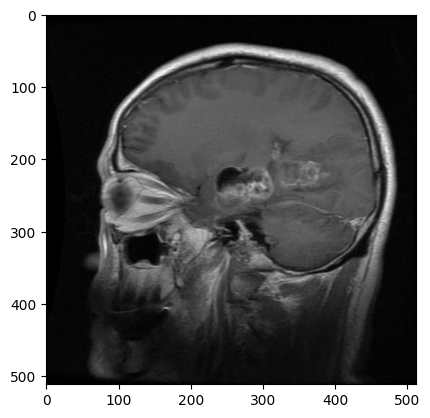

In [9]:
plt.imshow(images[50])

In [10]:
y = np.array([cv.resize(img,(112,112)) for img in images])
X = np.array([cv.resize(img,(112,112)) for img in images])

In [11]:
y = np.array(y)/255
X = np.array(X)/255

In [12]:
mean=0
sigma = 0.05
n = np.random.normal(loc=mean,scale=sigma,size=(112,112,1))
X = np.array([img+n for img in X])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


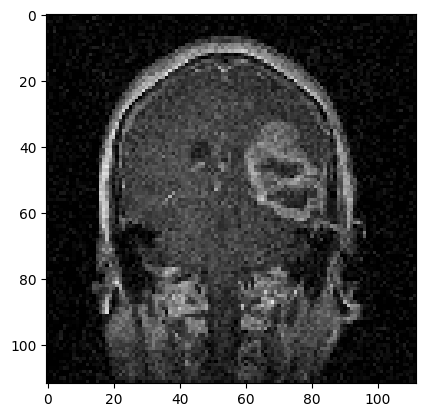

In [13]:
plt.imshow(X[20])

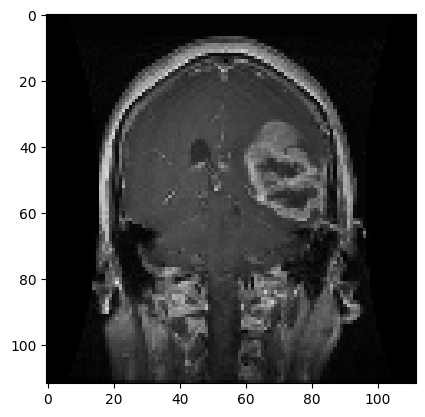

In [14]:
plt.imshow(y[20])

In [15]:
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

In [16]:
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
def residual_block_gen(ch=32,k_s=3,st=1):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.LeakyReLU(),
    ])
    return model

def Upsample_block(x, ch=64, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st),padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def get_enhancer():
        
    input_lr=tf.keras.layers.Input(shape=(112,112,3))
    input_conv=tf.keras.layers.Conv2D(32,5,padding='same')(input_lr)
    input_conv=tf.keras.layers.LeakyReLU()(input_conv)
    SRRes=input_conv
    
    for x in range(2):
        res_output=residual_block_gen()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,res_output])
        SRRes=tf.keras.layers.Conv2D(32,5,padding='same')(SRRes)
        SRRes=tf.keras.layers.BatchNormalization()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,input_conv])
        
    SRRes=Upsample_block(SRRes)
    output_sr=tf.keras.layers.Conv2D(3,5,activation='tanh',padding='same')(SRRes)

    return tf.keras.Model(input_lr,output_sr)

In [18]:
def Generator():
    model = keras.Sequential([

        keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3)),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu'),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu'),
        keras.layers.UpSampling2D(2),
        keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',activation='relu'),
        keras.layers.Conv2D(3,3,padding='same',activation='sigmoid')
        
    ])

    return model

In [19]:
inputs = layers.Input(shape=(112,112,3))
hidden = get_enhancer()(inputs)
outputs =  Generator()(hidden)
model = keras.Model(inputs,outputs)

In [20]:
model.compile(optimizer='Adam',loss='mse',metrics=[PSNR])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model (Functional)          (None, 224, 224, 3)       110643    
                                                                 
 sequential_2 (Sequential)   (None, 112, 112, 3)       191619    
                                                                 
Total params: 302,262
Trainable params: 302,134
Non-trainable params: 128
_________________________________________________________________


In [21]:
model.fit(X,y,epochs=20,batch_size=16)

Epoch 1/20
357/357 [==============================] - 62s 163ms/step - loss: 0.0075 - PSNR: 22.3702
Epoch 2/20
357/357 [==============================] - 59s 164ms/step - loss: 0.0031 - PSNR: 25.4267
Epoch 3/20
357/357 [==============================] - 59s 164ms/step - loss: 0.0024 - PSNR: 26.4244
Epoch 4/20
357/357 [==============================] - 59s 164ms/step - loss: 0.0020 - PSNR: 27.1350
Epoch 5/20
357/357 [==============================] - 59s 164ms/step - loss: 0.0017 - PSNR: 27.9590
Epoch 6/20
357/357 [==============================] - 59s 164ms/step - loss: 0.0015 - PSNR: 28.4688
Epoch 7/20
357/357 [==============================] - 58s 164ms/step - loss: 0.0014 - PSNR: 28.7373
Epoch 8/20
357/357 [==============================] - 58s 164ms/step - loss: 0.0012 - PSNR: 29.2825
Epoch 9/20
357/357 [==============================] - 58s 164ms/step - loss: 0.0012 - PSNR: 29.4970
Epoch 10/20
357/357 [==============================] - 58s 164ms/step - loss: 0.0011 - PSNR: 29.8312

In [23]:
mean=0
sigma = 0.05
n = np.random.normal(loc=mean,scale=sigma,size=(112,112,1))
x_test = np.array([img+n for img in X[:10]])

In [24]:
preds = model.predict(np.array(x_test))

1/1 [==============================] - 1s 791ms/step


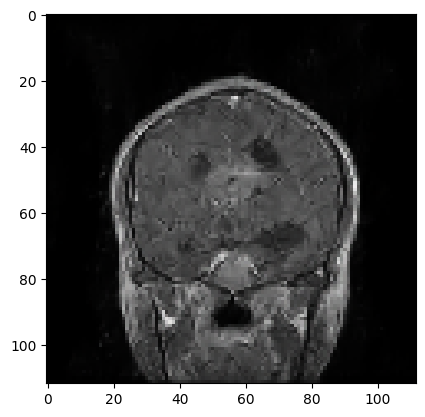

In [25]:
plt.imshow(preds[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


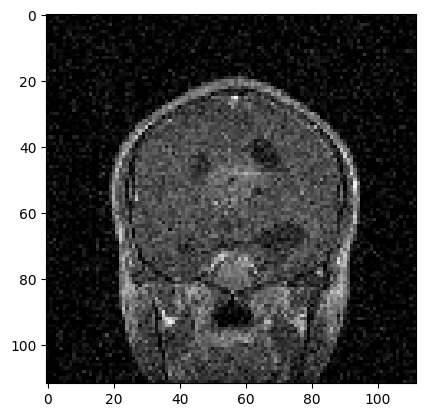

In [26]:
plt.imshow(x_test[1])

In [22]:
keras.models.save_model(model,'Denoiser_Enhancer2.h5')